In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from xgboost import XGBClassifier

from pyTrajectory.config import cfg
from pyTrajectory.io import load_dataset, save_dataset
from pyTrajectory.dataset import Dataset, AnnotatedGroup
from pyTrajectory.features import DataFrameFeatureExtractor
from classification_utils import classify_dataset, to_prediction_dataset, plot_confusion_matrix, plot_classification_timeline

from sklearn.impute import KNNImputer
from sklearn.utils.class_weight import compute_sample_weight
from scipy.signal import medfilt, savgol_filter

cfg.key_keypoints = "keypoints"
cfg.key_timestamp = "timestamps"

cfg.trajectory_keys = (
    "keypoints",
    "timestamps",
)

In [3]:
categories = tuple(np.unique(pd.read_csv("datasets/mice_train_annotations.csv")["category"]))
categories

('attack', 'investigation', 'mount', 'none')

In [4]:
dataset_train = load_dataset("mice_train", directory="datasets", target="dyads", categories=categories)
dataset_test = load_dataset("mice_test", directory="datasets", target="dyads", categories=categories)

In [5]:
extractor = DataFrameFeatureExtractor().read_yaml("config_file.yaml")

In [6]:
def subsample_train(dataset):
    global extractor
    X_subsample_even, y_subsample_even = dataset.subsample(
        extractor,
        0.1,
        pipeline=KNNImputer(),
        categories=("none", "investigation")
    )
    X_subsample_all, y_subsample_all = dataset.subsample(
        extractor,
        1.0,
        try_even_subsampling=False,
        pipeline=KNNImputer(),
        categories=("attack", "mount")
    )
    return pd.concat([X_subsample_even, X_subsample_all]), np.concatenate([y_subsample_even, y_subsample_all])

k_fold_results = []

for fold_dataset_train, fold_dataset_holdout in dataset_train.k_fold(5, exclude=[("intruder", "resident")]):
    X_train, y_train = subsample_train(fold_dataset_train)

    xgbc = XGBClassifier().fit(
        X_train.to_numpy(),
        fold_dataset_train.encode(y_train),
        sample_weight=compute_sample_weight("balanced", fold_dataset_train.encode(y_train)),
    )
    
    # k_fold_results.append(
    #     {filter_window:
    #         classify_dataset(
    #             xgbc,
    #             fold_dataset_holdout,
    #             extractor,
    #             pipeline=KNNImputer(),
    #             label_smoothing_filter_funcs=[lambda arr: medfilt(arr, 5), lambda arr: savgol_filter(arr, filter_window, 1)],
    #         ) for filter_window in tqdm(np.arange(3, 91, 2))
    #     }
    # )
    break

In [7]:
dataset_classification_result = classify_dataset(
    xgbc,
    fold_dataset_holdout,
    extractor,
    pipeline=KNNImputer(),
    # label_smoothing_filter_funcs=[lambda arr: medfilt(arr, 5), lambda arr: savgol_filter(arr, 53, 1)],
)

In [8]:
from classification_utils import interval_f1_score, plot_confusion_matrix

In [9]:
interval_f1_score(
    dataset_classification_result.predictions,
    dataset_classification_result.annotations,
    encode_func=dataset_train.encode,
    num_categories=len(dataset_train.categories),
)

array([[0.        , 0.50134771, 0.35897436, 0.53424658],
       [0.        , 0.56880734, 0.21621622, 0.5       ],
       [0.        , 0.54982818, 0.14736842, 0.47979798],
       [0.        , 0.54661558, 0.        , 0.4612326 ],
       [0.        , 0.43208279, 0.        , 0.60520095],
       [0.46052632, 0.34042553, 0.        , 0.46511628],
       [0.54901961, 0.23423423, 0.        , 0.3880597 ],
       [0.        , 0.44067797, 0.59016393, 0.53731343],
       [0.59898477, 0.1038961 , 0.        , 0.37931034],
       [0.        , 0.58461538, 0.        , 0.5840708 ],
       [0.        , 0.56103286, 0.        , 0.59548872],
       [0.        , 0.59452412, 0.36231884, 0.68096515],
       [0.        , 0.61988304, 0.        , 0.62251656],
       [0.        , 0.625     , 0.22857143, 0.66304348]])

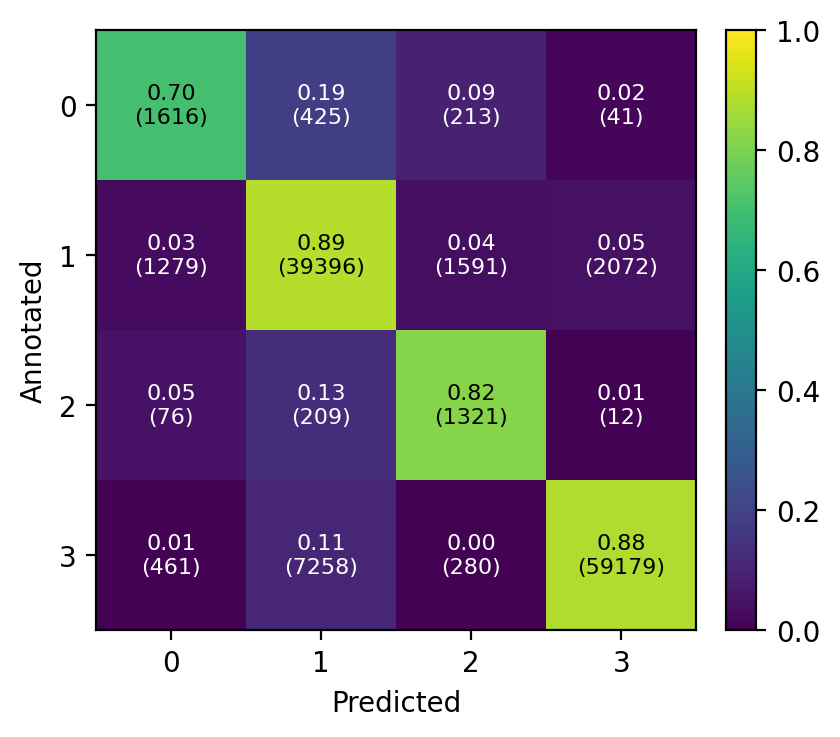

In [10]:
plot_confusion_matrix(
    dataset_classification_result.y_numeric,
    dataset_classification_result.y_pred_numeric,
)

In [30]:
from sklearn.metrics import f1_score

f1_score(
    dataset_train.encode(validate_predictions(dataset_classification_result.predictions, dataset_classification_result.annotations)["true_category"].to_numpy()),
    dataset_train.encode(dataset_classification_result.predictions["category"].to_numpy()),
    labels=range(len(dataset_train.categories)),
    average=None,
)

array([0.        , 0.39543726, 0.02380952, 0.3752495 ])

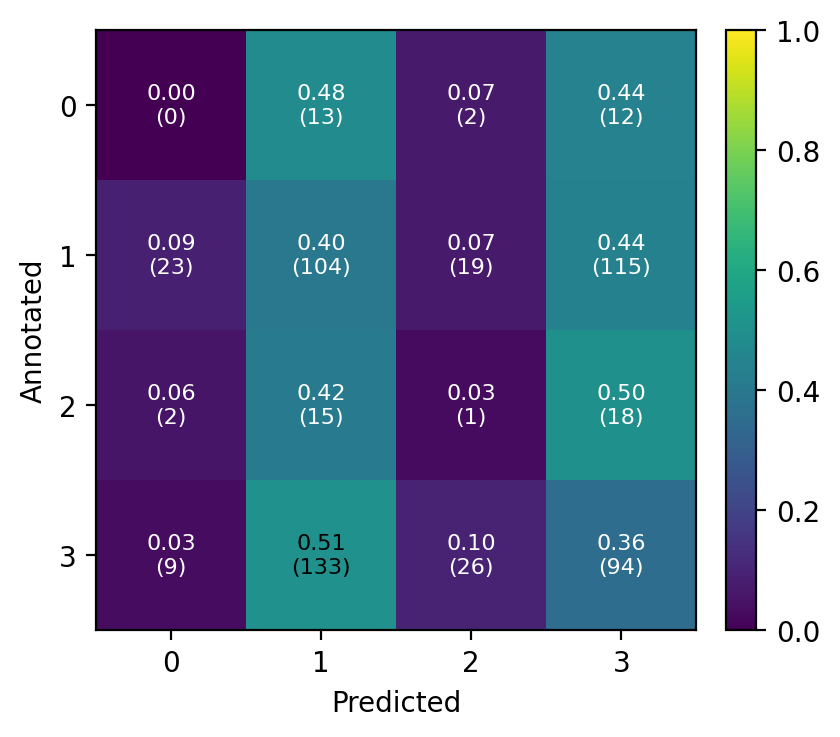

In [36]:
from classification_utils import plot_confusion_matrix

plot_confusion_matrix(
    dataset_train.encode(validate_predictions(dataset_classification_result.predictions, dataset_classification_result.annotations)["true_category"].to_numpy()),
    dataset_train.encode(dataset_classification_result.predictions["category"].to_numpy())
)

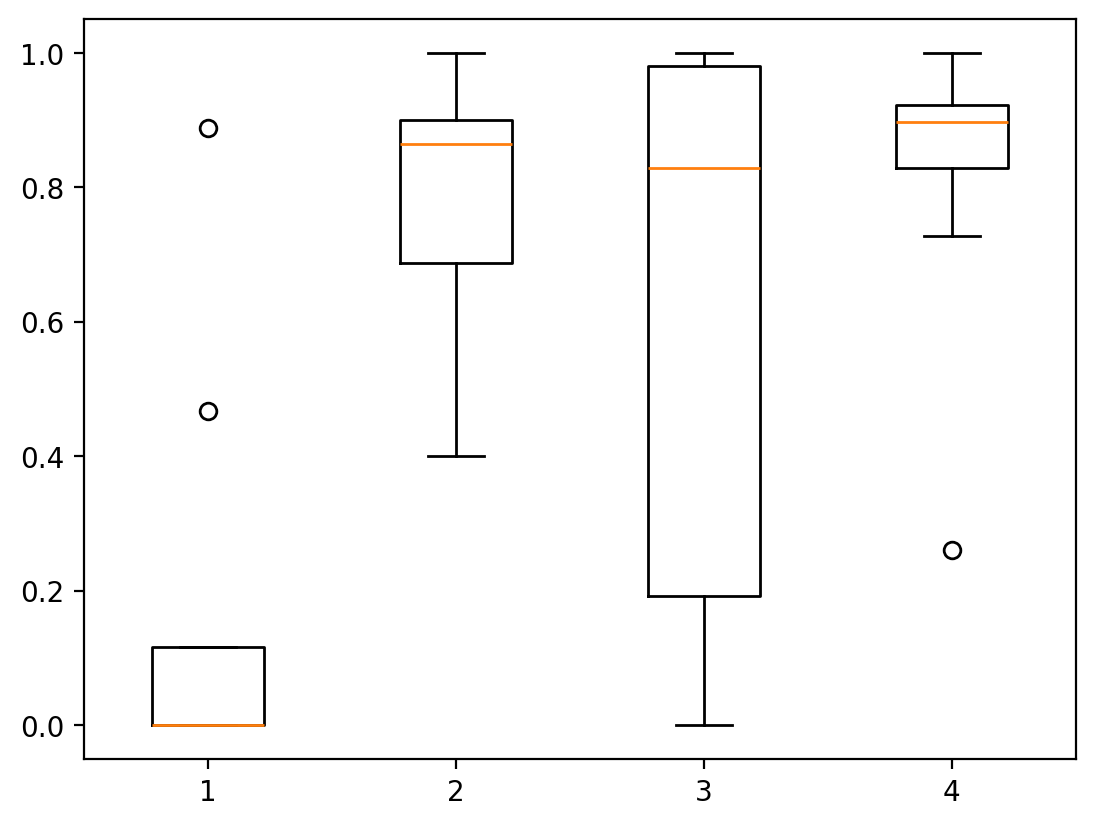

In [27]:
from classification_utils import validate_predictions, interval_f1_score

import matplotlib.pyplot as plt

plt.boxplot(
    [
        f1_scores[np.isfinite(f1_scores)]
        for f1_scores in
        interval_f1_score(
            dataset_classification_result.predictions,
            dataset_classification_result.annotations,
            encode_func=dataset_train.encode,
            num_categories=len(dataset_train.categories),
        ).T
    ]
)
plt.show()

In [ ]:
classification_result = classification_results_k_folds[0][12]["classification_results"][("resident", "intruder")]

In [ ]:
interval_f1_score(
    classification_results_k_folds[0][12]["predictions"],
    classification_results_k_folds[0][12]["annotations"],
    encode_func=dataset_train.encode,
    num_categories=len(classification_result["categories"]),
    on="predictions",
    average=None,
)

In [ ]:
validated = validate_predictions(classification_result["predictions"], classification_result["annotations"], on="predictions")
plot_confusion_matrix(dataset_train.encode(validated["true_category"].to_numpy()), dataset_train.encode(validated["category"].to_numpy()))

In [ ]:
from sklearn.metrics import f1_score

scores = []

for window_filter in tqdm(np.arange(3, 91, 2)):
    classification_results_k_folds = [result[window_filter] for result in k_fold_results]
    validated_annotations = pd.concat(
        [
            validate_predictions(classification_result["predictions"], classification_result["annotations"], on="annotations")
            for classification_results_k_fold in classification_results_k_folds
            for group_classification_result in classification_results_k_fold.values()
            for classification_result in group_classification_result["classification_results"].values()
        ]
    )
    validated_predictions = pd.concat(
        [
            validate_predictions(classification_result["predictions"], classification_result["annotations"], on="predictions")
            for classification_results_k_fold in classification_results_k_folds
            for group_classification_result in classification_results_k_fold.values()
            for classification_result in group_classification_result["classification_results"].values()
        ],
    )
    y_true = np.concatenate(
        [
            sampleable_results["y_numeric"]
            for classification_results_k_fold in classification_results_k_folds
            for group_results in classification_results_k_fold.values()
            for sampleable_results in group_results["classification_results"].values()
        ]
    )
    y_pred = np.concatenate(
        [
            sampleable_results["y_pred_numeric_smoothed"]
            for classification_results_k_fold in classification_results_k_folds
            for group_results in classification_results_k_fold.values()
            for sampleable_results in group_results["classification_results"].values()
        ]
    )
    scores.append(
        (
            f1_score(
                dataset_train.encode(validated_annotations["category"].to_numpy()),
                dataset_train.encode(validated_annotations["predicted_category"].to_numpy()),
                average=None,
            ),
            f1_score(
                dataset_train.encode(validated_predictions["true_category"].to_numpy()),
                dataset_train.encode(validated_predictions["category"].to_numpy()),
                average=None,
            ),
            f1_score(y_true, y_pred, average=None),
        )
    )

In [ ]:
scores = np.asarray(scores)

plt.plot(np.arange(3, 91, 2), np.mean(scores, axis=(1, 2)))
plt.show()

In [ ]:
classification_result_dataset_test = classify_dataset(
    xgbc,
    dataset_test,
    extractor,
    pipeline=KNNImputer(),
    label_smoothing_filter_funcs=[lambda arr: medfilt(arr, 5), lambda arr: savgol_filter(arr, 31, 1)],
    exclude=[("intruder", "resident")],
)
validated_annotations = pd.concat(
[
    validate_predictions(classification_result["predictions"], classification_result["annotations"], on="annotations")
    for group_classification_result in classification_result_dataset_test.values()
    for classification_result in group_classification_result["classification_results"].values()
]
)
validated_predictions = pd.concat(
    [
        validate_predictions(classification_result["predictions"], classification_result["annotations"], on="predictions")
        for group_classification_result in classification_result_dataset_test.values()
        for classification_result in group_classification_result["classification_results"].values()
    ],
)    
(
    f1_score(
        dataset_test.encode(validated_annotations["category"].to_numpy()),
        dataset_test.encode(validated_annotations["predicted_category"].to_numpy()),
        average=None,
    ),
    f1_score(
        dataset_test.encode(validated_predictions["true_category"].to_numpy()),
        dataset_test.encode(validated_predictions["category"].to_numpy()),
        average=None,
    ),
    f1_score(
        np.concatenate(
            [
                sampleable_results["y_numeric"]
                for group_results in classification_result_dataset_test.values()
                for sampleable_results in group_results["classification_results"].values()
            ]
        ),
        np.concatenate(
            [
                sampleable_results["y_pred_numeric_smoothed"]
                for group_results in classification_result_dataset_test.values()
                for sampleable_results in group_results["classification_results"].values()
            ]
        ),
        average=None,
    )
)

In [ ]:
X_train_subsample_even, y_train_subsample_even = dataset_train.subsample(
    extractor,
    0.1,
    pipeline=KNNImputer(),
    exclude=[("intruder", "resident")],
    categories=("none", "investigation")
)
X_train_subsample_all, y_train_subsample_all = dataset_train.subsample(
    extractor,
    1.0,
    try_even_subsampling=False,
    pipeline=KNNImputer(),
    exclude=[("intruder", "resident")],
    categories=("attack", "mount")
)

X_test, y_test = dataset_test.sample(
    extractor,
    pipeline=KNNImputer(),
    exclude=[("intruder", "resident")],
)

In [ ]:
xgbc = XGBClassifier().fit(
    X_train.to_numpy(),
    dataset_train.encode(y_train),
    sample_weight=compute_sample_weight("balanced", dataset_train.encode(y_train)),
)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
y_test_numeric = dataset_train.encode(y_test)
y_pred = xgbc.predict(X_test)

plot_confusion_matrix(y_test_numeric, y_pred, category_labels=["att", "inv", "mnt", "none"])

In [ ]:
f1_score(y_test_numeric, y_pred, average=None)

In [ ]:
from pyTrajectory.dataset.annotations.utils import check_annotations, infill_annotations
from pyTrajectory.dataset.utils import interval_overlap

from tqdm.auto import tqdm

In [ ]:
scores = []

for filter_window in tqdm(np.arange(3, 61, 2)):

    classification_result_dataset_test = classify_dataset(
        xgbc,
        dataset_test,
        extractor,
        pipeline=KNNImputer(),
        label_smoothing_filter_funcs=[lambda arr: medfilt(arr, 5), lambda arr: savgol_filter(arr, filter_window, 1)],
        exclude=[("intruder", "resident")],
    )
    validated_annotations = pd.concat(
    [
        validate_predictions(classification_result["predictions"], classification_result["annotations"], on="annotations")
        for group_classification_result in classification_result_dataset_test.values()
        for classification_result in group_classification_result["classification_results"].values()
    ]
    )
    validated_predictions = pd.concat(
        [
            validate_predictions(classification_result["predictions"], classification_result["annotations"], on="predictions")
            for group_classification_result in classification_result_dataset_test.values()
            for classification_result in group_classification_result["classification_results"].values()
        ],
    )    
    scores.append(
        (
            f1_score(
                dataset_test.encode(validated_annotations["category"].to_numpy()),
                dataset_test.encode(validated_annotations["predicted_category"].to_numpy()),
                average=None,
            ),
            f1_score(
                dataset_test.encode(validated_predictions["true_category"].to_numpy()),
                dataset_test.encode(validated_predictions["category"].to_numpy()),
                average=None,np.arange(3, 91, 2)
            ),
            f1_score(
                np.concatenate(
                    [
                        sampleable_results["y_numeric"]
                        for group_results in classification_result_dataset_test.values()
                        for sampleable_results in group_results["classification_results"].values()
                    ]
                ),
                np.concatenate(
                    [
                        sampleable_results["y_pred_numeric_smoothed"]
                        for group_results in classification_result_dataset_test.values()
                        for sampleable_results in group_results["classification_results"].values()
                    ]
                ),
                average=None,
            )
        )
    )

In [ ]:
scores = np.asarray(scores)
scores.shape

In [ ]:
plt.plot(np.arange(3, 61, 2), scores.mean(axis=-1))

In [ ]:
best = np.argmax(np.prod(scores.mean(axis=-1), axis=1))
np.arange(3, 61, 2)[best]

plt.plot(*scores.mean(axis=-1)[:, (0, 1)].T, "ko-")
# ax.vlines(scores[best, 0], ymin=0, ymax=scores[best, 1], color="r")
# ax.hlines(scores[best, 1], xmin=0, xmax=scores[best, 0], color="r")
plt.plot(*scores.mean(axis=-1)[best, (0, 1)], "ro")

# ax = plt.gca()
# ax.set_xlim(scores[:, 0].min() - 0.01, scores[:, 0].max() + 0.01)
# ax.set_ylim(scores[:, 1].min() - 0.01, scores[:, 1].max() + 0.01)

plt.show()

In [ ]:
plt.plot(*scores.mean(axis=-1)[:, (0, 2)].T, "ko-")
# ax.vlines(scores[best, 0], ymin=0, ymax=scores[best, 1], color="r")
# ax.hlines(scores[best, 1], xmin=0, xmax=scores[best, 0], color="r")
plt.plot(*scores.mean(axis=-1)[best, (0, 2)], "ro")

# ax = plt.gca()
# ax.set_xlim(scores[:, 0].min() - 0.01, scores[:, 0].max() + 0.01)
# ax.set_ylim(scores[:, 1].min() - 0.01, scores[:, 1].max() + 0.01)

plt.show()

In [ ]:
classification_result_dataset_test = classify_dataset(
    xgbc,
    dataset_test,
    extractor,
    pipeline=KNNImputer(),
    label_smoothing_filter_funcs=[lambda arr: medfilt(arr, 5), lambda arr: savgol_filter(arr, 31, 1)],
    exclude=[("intruder", "resident")],
)

In [ ]:
f1_score(
    np.concatenate(
        [
            sampleable_results["y_numeric"]
            for group_results in classification_result_dataset_test.values()
            for sampleable_results in group_results["classification_results"].values()
        ]
    ),
    np.concatenate(
        [
            sampleable_results["y_pred_numeric_smoothed"]
            for group_results in classification_result_dataset_test.values()
            for sampleable_results in group_results["classification_results"].values()
        ]
    ),
    average=None,
)

In [ ]:
per_frame = {}
for per_prediction in [{category: overlap} for category, overlap in zip(per_prediction_dataset["prediction"], per_prediction_dataset["overlap"])]:
    for category, overlap in per_prediction.items():
        for overlap_category, overlap_duration in overlap:
            if overlap_category not in per_frame:
                per_frame[overlap_category] = {}
            if category not in per_frame[overlap_category]:
                per_frame[overlap_category][category]  = 0
            per_frame[overlap_category][category] += overlap_duration

pd.DataFrame(per_frame)

In [ ]:
classification_result = classification_result_dataset_test[18]["classification_results"][("resident", "intruder")]

In [ ]:
plot_classification_timeline(
    categories=classification_result["categories"],
    predictions=classification_result["predictions"],
    annotations=classification_result["annotations"],
    y_proba_smoothed=classification_result["y_proba_smoothed"],
    interval=(-np.inf, np.inf),
    x_tick_step=30 * 60,
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
    category_labels=["att", "inv", "mnt", "none"],
    x_label="time (min)"
)

In [ ]:
plot_classification_timeline(
    categories=classification_result["categories"],
    predictions=classification_result["predictions"],
    annotations=classification_result["annotations"],
    y_proba=classification_result["y_proba"],
    y_proba_smoothed=classification_result["y_proba_smoothed"],
    interval=(-np.inf, np.inf),
    x_tick_step=30 * 60,
    x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
    category_labels=["att", "inv", "mnt", "none"],
    x_label="time (min)"
)

In [ ]:
for idx in range(19):
    classification_result = classification_result_dataset_test[idx]["classification_results"][("resident", "intruder")]
    plot_classification_timeline(
        categories=classification_result["categories"],
        predictions=classification_result["predictions"],
        annotations=classification_result["annotations"],
        # y_proba=classification_result["y_proba"],
        y_proba_smoothed=classification_result["y_proba_smoothed"],
        interval=(-np.inf, np.inf),
        x_tick_step=30 * 60,
        x_tick_conversion=lambda ticks: [int(tick / (30 * 60)) for tick in ticks],
        category_labels=["att", "inv", "mnt", "none"],
        x_label="time (min)"
    )
    plt.show()

In [ ]:
dataset_predictions_test = to_prediction_dataset(classification_result_dataset_test, target="dyads")

In [ ]:
save_dataset(dataset_predictions_test, directory="datasets", dataset_name="mice_predictions", annotation_type="predictions")

In [ ]:
from pyTrajectory.io import load_dataset

dataset_predictions = load_dataset(directory="datasets", target="dyads", categories=('attack', 'investigation', 'mount', 'none'), dataset_name="mice_predictions", annotation_type="predictions")

In [ ]:
from observation_library import ObservationLibrary
from glob import glob
import json

annotations = dataset_predictions.get_annotations(exclude=[("intruder", "resident")])

video_files = sorted(glob("/home/paul/Downloads/task1_videos_mp4/test/*.mp4"))
video_lookup = {idx: [video_file] for idx, video_file in enumerate(video_files)}
trajectory_lookup = {
    group: dataset_predictions.select(group).trajectories
    for group in (
        dataset_predictions.groups
        if isinstance(dataset_predictions.groups, dict)
        else range(len(dataset_predictions.groups))
    )
}

observation_library = ObservationLibrary(
    annotations,
    video_lookup=video_lookup,
    trajectory_lookup=trajectory_lookup,
    num_keypoints=7,
    filter_dependencies={
        "actor": ("group", ),
        "recipient": ("group", "actor"),
    },
    highlight_observations_mode="category",
    selected_observations_mode="dyad",
)

with open("render_settings.json", "r") as f:
    render_settings = json.load(f)
    for key in render_settings:
        setattr(observation_library.render_settings, key, render_settings[key])

observation_library